# FGD1


In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.7.1


### FGD1
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for FGD1.

In [2]:
gene_symbol = 'FGD1'
mane_tx_id = 'NM_004463.3'
mane_protein_id = 'NP_004454.2' # FYVE, RhoGEF and PH domain-containing protein 1 [Homo sapiens]

In [3]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.22") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')

from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 16 phenopackets
Individuals Processed: 100%|██████████| 16/16 [00:00<00:00, 51.25individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Hypertelorism,HP:0000316,16
Short stature,HP:0004322,16
Anteverted nares,HP:0000463,14
Short nose,HP:0003196,14
Shawl scrotum,HP:0000049,14
Broad palm,HP:0001169,11
Ptosis,HP:0000508,9
Long philtrum,HP:0000343,9
Widow's peak,HP:0000349,9
Broad foot,HP:0001769,8


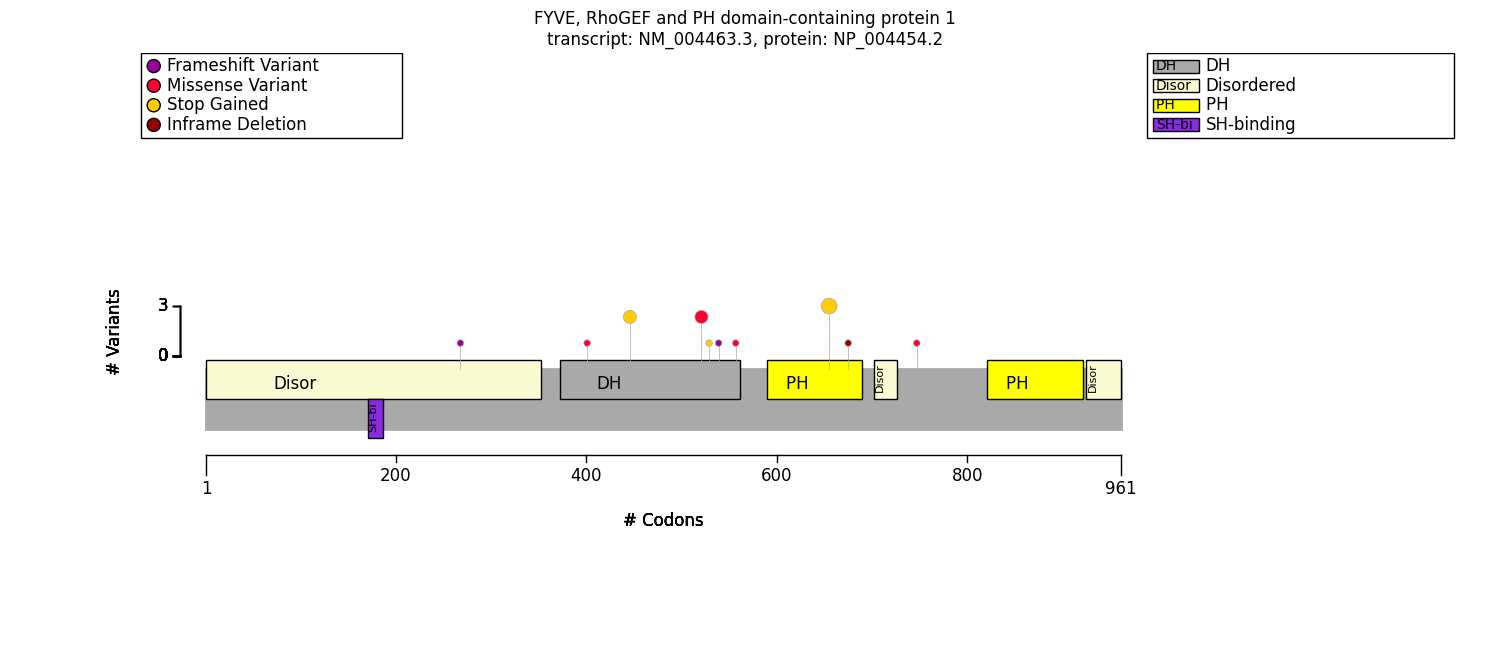

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)


fgd1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fgd1_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort=cohort)

Name,Type,Coordinates,Count,Variants
Disordered,REGION,1 - 353,1,p.Ala269ValfsTer91
SH3-binding,MOTIF,171 - 187,0,
DH,DOMAIN,373 - 561,8,p.Asp540GlufsTer11; p.Trp447Ter; p.Arg522His; p.Ser558Trp; p.Arg402Gln; p.Tyr530Ter
PH 1,DOMAIN,590 - 689,4,p.Arg656Ter; p.Glu676del
Disordered,REGION,702 - 726,0,
PH 2,DOMAIN,821 - 921,0,
Disordered,REGION,925 - 961,0,


In [7]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate
from gpsea.model import VariantEffect
from gpsea.view import MtcStatsViewer

missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_predicate = monoallelic_predicate(
    a_predicate=missense,
    b_predicate=~missense,
    a_label="Missense",
    b_label="Other"
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=missense_predicate,
    pheno_predicates=pheno_predicates,
)


viewer = MtcStatsViewer()
viewer.process(missense_result)



Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,6
HMF03,Skipping term because of a child term with the same individual counts,23
HMF08,Skipping general term,47
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,63


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       Missense          Other  \
                                                      Count Percent  Count   
Broad foot [HP:0001769]                                 0/3      0%    8/8   
Global developmental delay [HP:0001263]                 3/3    100%   2/10   
Long philtrum [HP:0000343]                              1/3     33%    8/8   
Anteverted nares [HP:0000463]                           3/5     60%  11/11   
Short nose [HP:0003196]                                 3/5     60%  11/11   
Metatarsus adductus [HP:0001840]                        0/3      0%   5/10   
Obesity [HP:0001513]                                    2/3     67%    2/8   
Umbilical hernia [HP:0001537]                           2/5     40%    1/9   
Curved linear dimple below the lower lip [HP:00...      1/3     33%    5/8   
Inguinal hernia [HP:0000023]                            2/5     40%    2/9   
Single transverse palmar crease [HP:0000954]            3/5     60%    3/8   
Hypertelorism [HP:0000316]                              5/5    100%  11/11   
Ptosis [HP:0000508]                                     3/5     60%   6/11   
Downslanted palpebral fissures [HP:0000494]             2/5     40%    5/9   
Slanting of the palpebral fissure [HP:0200006]          2/2    100%    5/5   
Broad palm [HP:0001169]                                 3/3    100%    8/8   
Abnormal palm morphology [HP:0100871]                   5/5    100%    8/8   
Camptodactyly [HP:0012385]                              1/3     33%    4/8   
Clinodactyly of the 5th finger [HP:0004209]             2/3     67%    6/8   
Finger clinodactyly [HP:0040019]                        2/2    100%    6/6   
Abnormal digit morphology [HP:0011297]                  4/4    100%    7/7   
Deviation of finger [HP:0004097]                        2/2    100%    6/6   
Abnormal finger morphology [HP:0001167]                 2/2    100%    6/6   
Deviation of the 5th finger [HP:0009179]                2/2    100%    6/6   
Short stature [HP:0004322]                              5/5    100%  11/11   
Abnormal axial skeleton morphology [HP:0009121]         3/3    100%    6/6   
Abnormality of the forehead [HP:0000290]                3/3    100%    7/7   
Abnormal nostril morphology [HP:0005288]                3/3    100%  11/11   
Abnormal nasal morphology [HP:0005105]                  3/3    100%  11/11   
Abnormal morphology of the nasal alae [HP:0000429]      3/3    100%  11/11   
Abnormality of the philtrum [HP:0000288]                3/3    100%    8/8   
Abnormal lip morphology [HP:0000159]                    3/3    100%    8/8   
Abnormal oral cavity morphology [HP:0000163]            3/3    100%  10/10   
Widow's peak [HP:0000349]                               3/5     60%    6/9   
High anterior hairline [HP:0009890]                     3/3    100%    6/6   
Shawl scrotum [HP:0000049]                              4/5     80%  10/11   
Abnormal scrotum morphology [HP:0000045]                4/4    100%  10/10   
Abnormal male external genitalia morphology [HP...      4/4    100%  10/10   
Delayed skeletal maturation [HP:0002750]                1/2     50%    4/6   
Cryptorchidism [HP:0000028]                             1/3     33%   6/11   
Abnormal testis morphology [HP:0000035]                 1/1    100%    6/6   

Allele group                                                                   \
                                                   Percent Corrected p values   
Broad foot [HP:0001769]                               100%           0.248485   
Global developmental delay [HP:0001263]                20%           0.683333   
Long philtrum [HP:0000343]                            100%           0.683333   
Anteverted nares [HP:0000463]                         100%           0.683333   
Short nose [HP:0003196]                               100%           0.683333   
Metatarsus adductus [HP:0001840]                       50%           1.000000 

In [10]:
dh = VariantPredicates.protein_feature(
    feature_id="DH", protein_metadata=protein_meta
)
dh_predicate = monoallelic_predicate(
    a_predicate=dh,
    b_predicate=~dh,
    a_label="DH domain",
    b_label="Other"
)
dh_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=dh_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=dh_result)

Allele group                                       DH domain         Other  \
                                                       Count Percent Count   
Single transverse palmar crease [HP:0000954]             5/6     83%   1/7   
Ptosis [HP:0000508]                                      7/8     88%   2/8   
Umbilical hernia [HP:0001537]                            3/6     50%   0/8   
Cryptorchidism [HP:0000028]                              1/6     17%   6/8   
Metatarsus adductus [HP:0001840]                         4/6     67%   1/7   
Inguinal hernia [HP:0000023]                             3/6     50%   1/8   
Anteverted nares [HP:0000463]                            6/8     75%   8/8   
Short nose [HP:0003196]                                  6/8     75%   8/8   
Shawl scrotum [HP:0000049]                               6/8     75%   8/8   
Broad foot [HP:0001769]                                  2/4     50%   6/7   
Clinodactyly of the 5th finger [HP:0004209]              2/4     50%   6/7   
Obesity [HP:0001513]                                     2/4     50%   2/7   
Widow's peak [HP:0000349]                                3/6     50%   6/8   
Global developmental delay [HP:0001263]                  3/6     50%   2/7   
Hypertelorism [HP:0000316]                               8/8    100%   8/8   
Downslanted palpebral fissures [HP:0000494]              3/6     50%   4/8   
Slanting of the palpebral fissure [HP:0200006]           3/3    100%   4/4   
Broad palm [HP:0001169]                                  4/4    100%   7/7   
Abnormal palm morphology [HP:0100871]                    6/6    100%   7/7   
Camptodactyly [HP:0012385]                               2/4     50%   3/7   
Finger clinodactyly [HP:0040019]                         2/2    100%   6/6   
Abnormal digit morphology [HP:0011297]                   4/4    100%   7/7   
Deviation of finger [HP:0004097]                         2/2    100%   6/6   
Abnormal finger morphology [HP:0001167]                  2/2    100%   6/6   
Deviation of the 5th finger [HP:0009179]                 2/2    100%   6/6   
Short stature [HP:0004322]                               8/8    100%   8/8   
Frontal bossing [HP:0002007]                             1/4     25%   3/7   
Abnormal axial skeleton morphology [HP:0009121]          5/5    100%   4/4   
Abnormality of the forehead [HP:0000290]                 4/4    100%   6/6   
Abnormal nostril morphology [HP:0005288]                 6/6    100%   8/8   
Abnormal nasal morphology [HP:0005105]                   6/6    100%   8/8   
Abnormal morphology of the nasal alae [HP:0000429]       6/6    100%   8/8   
Long philtrum [HP:0000343]                               3/4     75%   6/7   
Abnormality of the philtrum [HP:0000288]                 5/5    100%   6/6   
Abnormal lip morphology [HP:0000159]                     5/5    100%   6/6   
Abnormal oral cavity morphology [HP:0000163]             7/7    100%   6/6   
Curved linear dimple below the lower lip [HP:00...       2/4     50%   4/7   
High anterior hairline [HP:0009890]                      3/3    100%   6/6   
Midface retrusion [HP:0011800]                           1/4     25%   3/7   
Abnormal scrotum morphology [HP:0000045]                 6/6    100%   8/8   
Abnormal male external genitalia morphology [HP...       6/6    100%   8/8   
Delayed skeletal maturation [HP:0002750]                 1/1    100%   4/7   
Abnormal testis morphology [HP:0000035]                  1/1    100%   6/6   

Allele group                                                                   \
                                                   Percent Corrected p values   
Single transverse palmar crease [HP:0000954]           14%           0.787546   
Ptosis [HP:0000508]                                    25%           0.787546   
Umbilical hernia [HP:0001537]                           0%           0.787546   
Cryptorchidism [HP:0000028]                            75%           0.882051   
Met

# Summary

In [11]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary


f_results = (
    GPAnalysisResultSummary.from_mono(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_mono(
        result=dh_result,
    ),
)

caption = "No statistically significant results identified."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=f_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [12]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
Missense,Other,41,0
Genotype (A),Genotype (B),Tests performed,Significant tests
DH domain,Other,43,0


In [13]:
summarizer.process_latex(report=report, protein_fig=fgd1_fig)

Figure saved to ../../supplement/img/FGD1_protein_diagram-draft.pdf
Output to ../../supplement/tex/FGD1_summary_draft.tex
